---
---

<img src="../DONNEES/LOGO_PARIS1.png" width=160px align="right"></span>
<img src="../DONNEES/LOGO_MOSEF.jpeg" width=90px align="right"></span>

# <span style="background-color: "> **_Analyse de sentiment : Prédire si une critique de film est positive ou négative_** </span>

### **_PROJET MACHINE LEARNING AVANCEE_**

<div style="text-align:right;">Mars 2023</div>

**<div style="text-align:right;">Projet réalisé par : Baptiste Gautier, Oussama Laaumari, Anis Louissi, Camil Zahi</div>**
**<div style="text-align:right;">Supervisé par : Grégory Futhazar</div>**

---

---
#  Préparation des Données

In [1]:
# Installation des librairies

!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 32.4 MB/s eta 0:00

In [2]:
# Importation des librairies

from datasets import load_dataset
from datasets import load_metric
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from transformers import Trainer, TrainingArguments
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Charger le jeu de données IMDB Movie Expressed Sentiment 2 depuis le BigScience/P3 et l'afficher

dataset = load_dataset("bigscience/P3", "imdb_Movie_Expressed_Sentiment_2")
dataset

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# Afficher les premières lignes des jeux de données

print(dataset["train"][1])
print(dataset["test"][1])
print(dataset["unsupervised"][1])

In [ ]:
# Récupérer les différents ensembles à partir du jeu de données

train_data = dataset['train']
test_data = dataset['test']
unsupervised_data = dataset['unsupervised']

# Statistique Descriptives

In [ ]:
# Taille des jeux de données

print(f"Taille du train set : {len(train_data)}")
print(f"Taille du test set : {len(test_data)}")
print(f"Taille du unsupervised set : {len(unsupervised_data)}")

Taille du train set : 25000
Taille du test set : 25000
Taille du unsupervised set : 50000


In [ ]:
# Compter les mots dans chaque ensemble

word_counter = Counter()
for subset in [train_data, test_data, unsupervised_data]:
    for review in subset['inputs_pretokenized']:
        word_counter.update(review.split())

# Taille du vocabulaire
vocab_size = len(word_counter)

print(f"Taille du vocabulaire : {vocab_size}")

Taille du vocabulaire : 634542


Nombre moyen de mots par phrase : Train=208.33, Test=205.48, Unsupervised=208.69


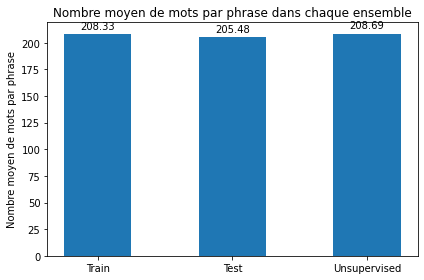

In [ ]:
# Nombre moyen de mots par phrase dans chaque ensemble
from src.vizualisation import compute_average_word_count, plot_average_word_count

train_word_count, test_word_count, unsupervised_word_count = compute_average_word_count(train_data, test_data, unsupervised_data)
print(f"Nombre moyen de mots par phrase : Train={train_word_count:.2f}, Test={test_word_count:.2f}, Unsupervised={unsupervised_word_count:.2f}")

plot_average_word_count(train_word_count, test_word_count, unsupervised_word_count)

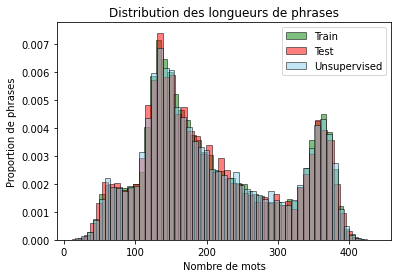

In [ ]:
# Distribution des longueurs de phrases
from src.vizualisation import plot_sentence_lengths_histogram 
plot_sentence_lengths_histogram([train_data, test_data, unsupervised_data], ['Train', 'Test', 'Unsupervised'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


10 mots les plus fréquents (sans stop words, balises HTML et termes indésirables) : [('movie', 53132), ('film', 23729), ('one', 17945), ('like', 15852), ('would', 10313), ('good', 10064), ('really', 9541), ('even', 9063), ('see', 8882), ('-', 8082)]


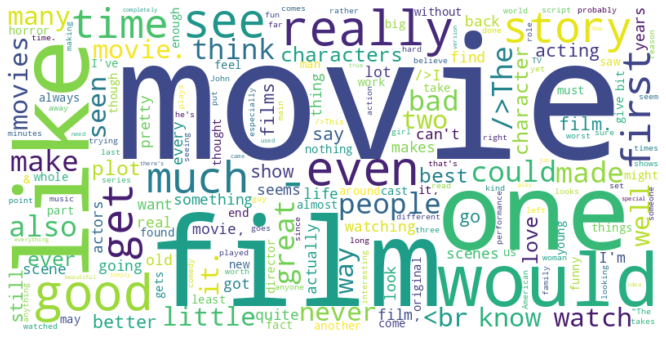

In [ ]:
# Fréquence des mots
from src.data_utils import clean_review, create_word_counter, get_top_n_words
from src.vizualisation import generate_wordcloud, display_wordcloud

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

word_counter = create_word_counter(train_data)

print(f"10 mots les plus fréquents (sans stop words, balises HTML et termes indésirables) : {get_top_n_words(word_counter, 10)}")

# Générer le nuage de mots à partir du word_counter
wordcloud = generate_wordcloud(word_counter)
display_wordcloud(wordcloud)

In [ ]:
# Analyse des émoticônes et des ponctuations
from src.vizualisation import count_emoticons_and_punctuation, plot_emoticons_punctuation_separate

train_emoticons, train_punctuation = count_emoticons_and_punctuation(train_data)
test_emoticons, test_punctuation = count_emoticons_and_punctuation(test_data)
unsupervised_emoticons, unsupervised_punctuation = count_emoticons_and_punctuation(unsupervised_data)

print(f"Nombre d'émoticônes et de ponctuations : Train ({train_emoticons}, {train_punctuation}), Test ({test_emoticons}, {test_punctuation}), Unsupervised ({unsupervised_emoticons}, {unsupervised_punctuation})")
train_size = len(train_data)
test_size = len(test_data)
unsupervized_size = len(unsupervized_data)
plot_emoticons_punctuation_separate(train_emoticons, train_punctuation, test_emoticons, test_punctuation, unsupervised_emoticons, unsupervised_punctuation, train_size, test_size, unsupervised_size)

Nombre d'émoticônes et de ponctuations : Train (396, 655604), Test (385, 649302), Unsupervised (798, 1311202)


TypeError: ignored

# Entrainement du Modèle

In [ ]:
# Charger le tokenizer DistilBert pré-entraîné pour convertir les textes en séquences d'identifiants de tokens compréhensibles par le modèle

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
from src.data_utils import tokenize_function, label_to_int
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Appliquer la fonction de conversion des étiquettes sur l'ensemble de données tokenisé

int_labeled_dataset = tokenized_dataset.map(label_to_int)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# Séparer l'ensemble de données tokenisé et étiqueté en int_labeled_dataset en ensembles d'apprentissage et de test

train_dataset = int_labeled_dataset['train']
test_dataset = int_labeled_dataset['test']

In [ ]:
# Charger le modèle DistilBert pré-entraîné pour la classification de séquences avec 2 labels (positif et négatif)

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [ ]:
from src.model import compute_metrics, get_trainer

trainer = get_trainer(model, train_dataset, test_dataset)
trainer.train()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/content/src/model.py:21: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


AttributeError: ignored

In [ ]:
# Évaluer le modèle entraîné sur l'ensemble de données de test et afficher les résultats

evaluation_results = trainer.evaluate(test_dataset)
print(evaluation_results)

AttributeError: ignored

In [ ]:
# Afficher les mots les plus distictifs

# Filtrer les critiques positives
train_data_negative = train_data_df[train_data_df["targets_pretokenized"] == " negative"]
train_data_positive = train_data_df[train_data_df["targets_pretokenized"] == " positive"]

# Nettoyer les critiques
train_data_negative['cleaned_review'] = train_data_negative['inputs_pretokenized'].apply(clean_review)
train_data_positive['cleaned_review'] = train_data_positive['inputs_pretokenized'].apply(clean_review)

# Créer un TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Calculer les scores TF-IDF pour les critiques négatives et positives
tfidf_negative = vectorizer.fit_transform(train_data_negative['cleaned_review'])
tfidf_positive = vectorizer.fit_transform(train_data_positive['cleaned_review'])

# Trouver les mots les plus distinctifs pour les critiques négatives et positives
negative_top_words = [vectorizer.get_feature_names_out()[idx] for idx in tfidf_negative.mean(axis=0).argsort()[0, -50:][::-1]]
positive_top_words = [vectorizer.get_feature_names_out()[idx] for idx in tfidf_positive.mean(axis=0).argsort()[0, -50:][::-1]]

print(f"50 mots les plus distinctifs pour les critiques négatives : {negative_top_words}")
print(f"50 mots les plus distinctifs pour les critiques positives : {positive_top_words}")

NameError: ignored

---
Fin
---
---